In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir           = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

# pompjax imports
from utils_local.misc import amro2title, amro2cute
import matplotlib.pyplot as plt

from eval.calibration import calibration
from utils import create_df_response


In [3]:
#### create scenarios ####
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
            'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
            "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_scenarios = os.path.join(results2_dir, "synthetic_inferences", "abm")


In [8]:
from pyro.ops.stats import crps_empirical
from tqdm import tqdm
import torch

for idx_amro, amro in enumerate(amro_search):
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

    error_df       = pd.DataFrame()


    for idx_row, row in tqdm(scenarios_df.iterrows(), total=len(scenarios_df)):
        inference = np.load(os.path.join(path_to_save, "infer_building",
                                        f"scenario{idx_row+1}", f"{str(0).zfill(3)}posterior.npz"))

        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        θtruth    = inference["teta_truth"]
        idx_infer = inference["idx_infer"]
        Nif       = θpost.shape[-1]

        θpost     = np.mean(θpost, -2)

        truth               = np.squeeze(np.expand_dims(θtruth[:,0], -1)* np.ones((1, 1, Nif)))
        error               = np.array(crps_empirical(torch.tensor(θpost.transpose(1, 0, 2)), torch.tensor(truth)))
        err_df              = pd.DataFrame(columns=["value", "variable", "parameter", "scenario", "amro"])
        err_df["value"]      = list(error[0, :]) + list(error[1, :])
        err_df["parameter"] = list(["rho"]*Nif) + list(["beta"]*Nif)
        err_df["scenario"]  = f"scenario{idx_row+1}"
        err_df["variable"]  = f"crps"
        err_df["amro"]      = amro
        error_df            = pd.concat([error_df, err_df])


    error_df.to_csv(os.path.join(path_to_save, "infer_building", "param_error.csv"), index=False)


Running IF-EAKF for amro:  E. coli


100%|██████████| 10/10 [00:00<00:00, 24.35it/s]


Running IF-EAKF for amro:  K. pneumoniae


100%|██████████| 10/10 [00:00<00:00, 28.48it/s]


Running IF-EAKF for amro:  P. aeruginosa


100%|██████████| 10/10 [00:00<00:00, 28.42it/s]


Running IF-EAKF for amro:  MSSA


100%|██████████| 10/10 [00:00<00:00, 31.69it/s]


Running IF-EAKF for amro:  MRSA


 90%|█████████ | 9/10 [00:00<00:00, 31.53it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/chaosdonkey06/Dropbox/shaman-lab/amr-hospitals/results2/synthetic_inferences/abm/mrsa/infer_building/scenario10/000posterior.npz'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/chaosdonkey06/Dropbox/shaman-lab/amr-hospitals/results2/synthetic_inferences/abm/mrsa/infer_building/param_error.csv'

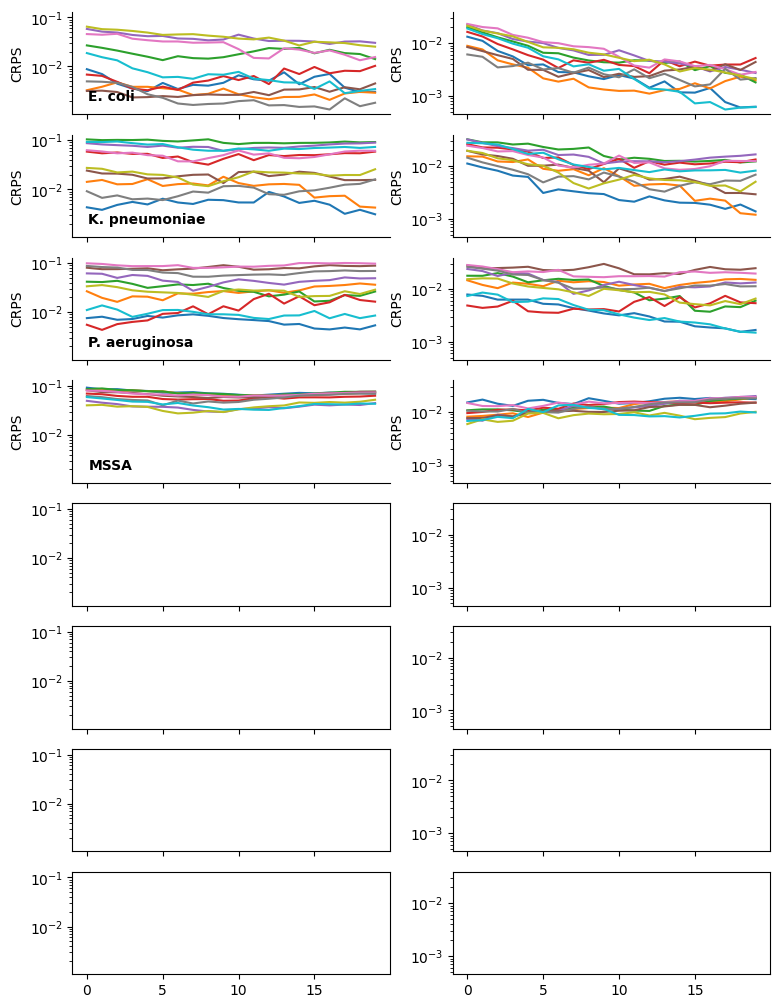

In [13]:
import seaborn as sns

fig, axes = plt.subplots(len(amro_search), 2, figsize=(9, 12.5), sharex=True, sharey="col")

for idx_amro, amro in enumerate(amro_search):
    path_to_save               = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
    p_error_df                 = pd.read_csv(os.path.join(path_to_save, "infer_building", "param_error.csv"))
    p_error_df["if_iter"]      = flatten_list([range(20)] * int(len(p_error_df) / 20))
    p_error_df["scenario_plt"] = p_error_df["scenario"].apply(lambda x: x.replace("scenario", "Scenario "))

    sns.lineplot(ax=axes[idx_amro, 0], data=p_error_df[p_error_df.parameter=="rho"], x="if_iter", y="value", hue="scenario_plt",   palette="tab10", legend=False)
    sns.lineplot(ax=axes[idx_amro, 1], data=p_error_df[p_error_df.parameter=="beta"], x="if_iter", y="value", hue="scenario_plt",  palette="tab10", legend=True)
    axes[idx_amro, 0].spines['right'].set_visible(False); axes[idx_amro, 1].spines['right'].set_visible(False)
    axes[idx_amro, 0].spines['top'].set_visible(False); axes[idx_amro, 1].spines['top'].set_visible(False)

    axes[idx_amro, 0].text(x=0.1, y=0.002, s=f"{amro2title(amro)}", weight='bold')
    axes[idx_amro, 1].legend().remove()

    axes[idx_amro, 0].set_ylabel(r"CRPS")
    axes[idx_amro, 1].set_ylabel(r"CRPS")

    axes[idx_amro, 0].set_yscale("log")
    axes[idx_amro, 1].set_yscale("log")

axes[0, 0].set_title(r"CRPS$\left(\rho, \rho_{{truth}}\right)$")
axes[0, 1].set_title(r"CRPS$\left(\beta, \beta_{{truth}}\right)$")

axes[-1, 0].set_xlabel("IF iteration")
axes[-1, 1].set_xlabel("IF iteration")
axes[0, 1].legend(title="Scenario", loc="upper right", bbox_to_anchor=(1.45, 1.1), ncol=1)
